# 🎯 Real-Time Suspicious Activity Detection
👁️ **Computer Vision** | 🧠 **Deep Learning** | 🏃 **Real-Time Tracking**

---

### 📌 **Summary**

In this notebook, we develop an **end-to-end system** to detect and classify suspicious behaviors, like shoplifting, from video feeds.  
The goal is to move beyond simple video classification and create a **real-time pipeline** that can track individuals and identify specific, "atomic" actions as they happen.

We combine **object detection**, **tracking**, and a **custom-trained action recognition model** to build a system capable of flagging potential threats with **explainable predictions**.

---

## 🚀 **Techniques Used**

### ✅ **Person Detection & Tracking**

- Utilized a pre-trained **YOLOv8** model for robust person detection in various environments.
- Implemented tracking to assign a **unique, persistent ID** to each person, allowing for individual analysis across frames.

### ✅ **Atomic Action Recognition**

- Curated a **custom dataset** of short video clips from the source footage, labeled with specific **atomic actions** like *concealing*, *loitering*, and *normal*.
- This **granular approach** allows the model to learn the building blocks of suspicious behavior.

### ✅ **Video Classification Model (CNN + LSTM)**

- Built a deep learning model combining:
  - A pre-trained **MobileNetV2** as the **CNN feature extractor**.
  - An **LSTM** layer to learn temporal patterns across frames.
- The CNN analyzes **spatial features**, while the LSTM learns **temporal dynamics** that define an action.

### ✅ **Real-Time Inference Pipeline**

- Developed a script that integrates the **YOLO tracker** and the **action classifier**.
- The pipeline:
  - Processes the video
  - Tracks individuals
  - Captures their recent frames
  - Feeds them into the model for **live action predictions**

---

## 📊 **Behavioral Analyses & Visualizations**

### 🎥 **Live Action Labeling**
- The output video annotates each tracked person with their **predicted action** (e.g., *concealing*) and a **confidence score**.

### 📈 **Suspicion Scoring System (Planned)**
- The framework is designed to support a **rule-based scoring system**.
- Different actions can be assigned points to compute a **dynamic suspicion score** for each person.

### 🖼️ **Output Visualization**
- The final output video is generated with **OpenCV** and includes:
  - **Bounding boxes**
  - **Track IDs**
  - **Real-time action labels**

This provides an **intuitive and comprehensive visual summary** of the system’s analysis.

---

> 💡 *This notebook showcases the power of combining modern deep learning techniques for actionable, real-time surveillance insights.*


In [11]:
import os
import cv2
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, TimeDistributed, LSTM, Dense, GlobalAveragePooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [12]:
# sample vid
video_path = 'anti_shoplift_system/shoplifting/shoplifting-3.mp4'

cap = cv2.VideoCapture(video_path)
if not cap.isOpened():
    print("Error: Could not open video.")
else:
    frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    fps = int(cap.get(cv2.CAP_PROP_FPS))
    width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    
    print(f"Video loaded successfully!")
    print(f"Resolution: {width}x{height}")
    print(f"FPS: {fps}")
    print(f"Total Frames: {frame_count}")

cap.release()

Video loaded successfully!
Resolution: 640x480
FPS: 30
Total Frames: 335


In [13]:
from ultralytics import YOLO
model = YOLO('yolov8n.pt')

cap = cv2.VideoCapture(video_path)
ret, frame = cap.read()


0: 480x640 1 person, 40.4ms
Speed: 1.0ms preprocess, 40.4ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


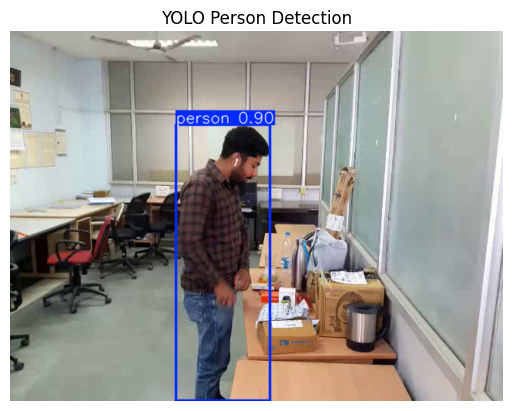

In [14]:
if ret:
    results = model(frame, classes=0)
    
    annotated_frame = results[0].plot()

    plt.imshow(cv2.cvtColor(annotated_frame, cv2.COLOR_BGR2RGB))
    plt.title("YOLO Person Detection")
    plt.axis('off') 
    plt.show()

cap.release()

In [3]:
DATA_DIR = 'anti_shoplift_system'
ACTION_CLASSES = ['concealing', 'loitering', 'normal']
NUM_CLASSES = len(ACTION_CLASSES)

In [4]:
MAX_FRAMES = 20  
IMG_SIZE = 128

In [5]:
def load_video_frames(video_path):
    """Loads, preprocesses, and standardizes frames from a single video."""
    frames = []
    cap = cv2.VideoCapture(video_path)
    
    while True:
        ret, frame = cap.read()
        if not ret:
            break
        
        frame = cv2.resize(frame, (IMG_SIZE, IMG_SIZE))
        frame = frame / 255.0 
        frames.append(frame)
        
        if len(frames) == MAX_FRAMES:
            break
            
    cap.release()
    while len(frames) < MAX_FRAMES:
        frames.append(np.zeros((IMG_SIZE, IMG_SIZE, 3)))
        
    return np.array(frames)

In [6]:
print("Loading data...")
X = []
y = [] 

for class_index, class_name in enumerate(ACTION_CLASSES):
    class_dir = os.path.join(DATA_DIR, class_name)
    print(f"Processing class: {class_name}")
    
    for video_file in os.listdir(class_dir):
        video_path = os.path.join(class_dir, video_file)
        frames = load_video_frames(video_path)
        
        X.append(frames)
        y.append(class_index)

print("Data loading complete.")

Loading data...
Processing class: concealing
Processing class: loitering
Processing class: normal
Data loading complete.


In [7]:
X = np.array(X)
y = np.array(y)
y_one_hot = to_categorical(y, num_classes=NUM_CLASSES)

X_train, X_val, y_train, y_val = train_test_split(X, y_one_hot, test_size=0.20, random_state=42, stratify=y)

print(f"Data shapes: X_train: {X_train.shape}, y_train: {y_train.shape}, X_val: {X_val.shape}, y_val: {y_val.shape}")


Data shapes: X_train: (19, 20, 128, 128, 3), y_train: (19, 3), X_val: (5, 20, 128, 128, 3), y_val: (5, 3)


In [8]:
print("Building the model...")
base_model = MobileNetV2(input_shape=(IMG_SIZE, IMG_SIZE, 3), include_top=False, weights='imagenet')
base_model.trainable = False 
model = Sequential([
    Input(shape=(MAX_FRAMES, IMG_SIZE, IMG_SIZE, 3)),
    TimeDistributed(base_model),
    TimeDistributed(GlobalAveragePooling2D()),
    LSTM(64),
    
    # Add a Dropout layer to help prevent overfitting
    Dropout(0.5),
    
    Dense(NUM_CLASSES, activation='softmax')
])

model.summary()

Building the model...


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ time_distributed                │ (None, 20, 4, 4, 1280) │     2,257,984 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_1              │ (None, 20, 1280)       │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 64)             │       344,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 3)              │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,602,499 (9.93 MB)

 Trainable params: 344,515 (1.31 MB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [9]:
print("Compiling and training the model...")

model.compile(optimizer='adam', 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

history = model.fit(X_train, y_train, 
                    epochs=30,  
                    batch_size=4,
                    validation_data=(X_val, y_val))

print("Training complete. Saving model...")
model.save('action_recognition_model.h5')
# Also save the class names for later use during inference
with open('action_classes.txt', 'w') as f:
    for item in ACTION_CLASSES:
        f.write("%s\n" % item)
        
print("Model and class labels saved.")

Compiling and training the model...
Epoch 1/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 44s 3s/step - accuracy: 0.2266 - loss: 1.3707 - val_accuracy: 0.2000 - val_loss: 1.3338
Epoch 2/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 120ms/step - accuracy: 0.6895 - loss: 0.8739 - val_accuracy: 0.4000 - val_loss: 1.2191
Epoch 3/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 120ms/step - accuracy: 0.5819 - loss: 0.8475 - val_accuracy: 0.6000 - val_loss: 1.1448
Epoch 4/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 118ms/step - accuracy: 0.6831 - loss: 0.8961 - val_accuracy: 0.8000 - val_loss: 1.0943
Epoch 5/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 118ms/step - accuracy: 0.6413 - loss: 0.7343 - val_accuracy: 0.8000 - val_loss: 1.0466
Epoch 6/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 117ms/step - accuracy: 0.7421 - loss: 0.6546 - val_accuracy: 0.8000 - val_loss: 1.0544
Epoch 7/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 116ms/step - accuracy: 0.9545 - loss: 0.4947 - val_accuracy: 0.8000 - val_loss: 1.1137
Epoch 8/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 118ms/step - accuracy: 0.9126 - loss: 0.4774 

Training complete. Saving model...
Model and class labels saved.


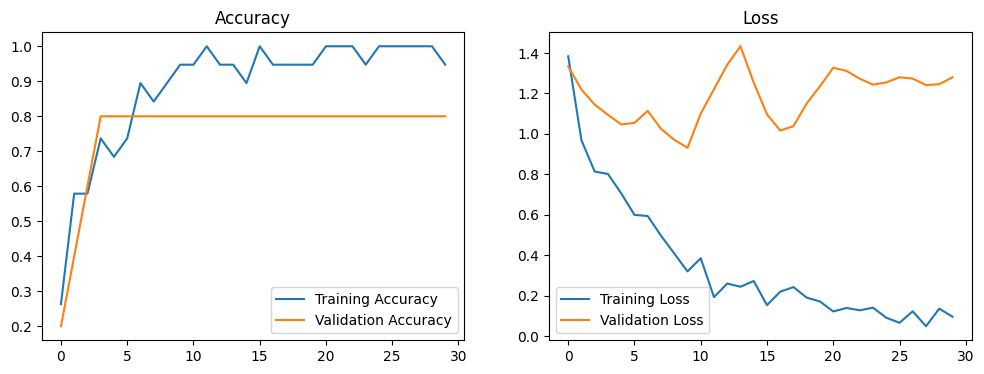

In [10]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title('Accuracy')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Loss')

plt.show()

In [ ]:
p